# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import cv2

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
import numpy as np
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[65].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("Label data = ", y_train[39200])

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Label data =  42


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

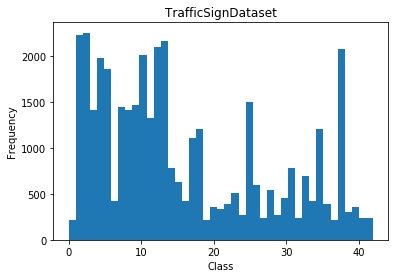

Training data set distribution before data augmentation


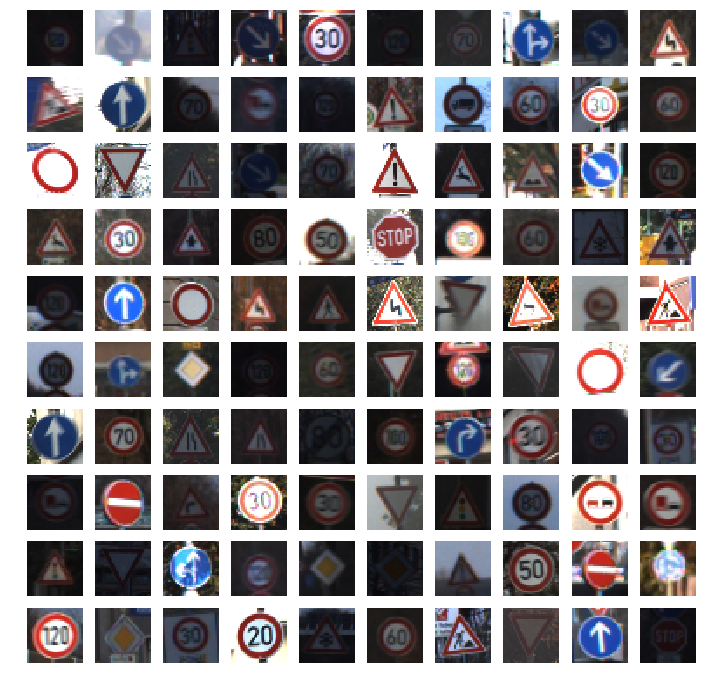

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
%matplotlib inline
plt.hist(y_train, n_classes)
plt.title("TrafficSignDataset")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

print("Training data set distribution before data augmentation")
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
plt.figure(figsize=(12,12))
random_image_idx = random.sample(range(0, n_train), 100)
for i in range(100):   #plot some random images from training set
    plt.subplot(10,10,i+1)
    plt.imshow(X_train[random_image_idx[i]])
    plt.axis('off')
plt.show()


# Preprocessing image
This step is to preprocess the image and return it

In [4]:
def convert_gray_scale(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to gray
    return gray_img
def preprocess_img(img):
    gray_img = convert_gray_scale(img)
    img_normalized = ((gray_img - np.min(gray_img)) * 255.) / ( np.max(gray_img) -  np.min(gray_img)) #normalize
    return img_normalized

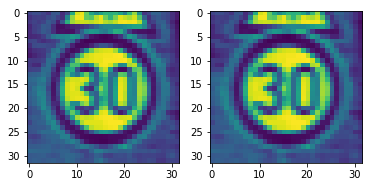

In [5]:
#test preprocessing
plt.subplot(1,2,1)
plt.imshow(convert_gray_scale(X_train[1000]))
plt.subplot(1,2,2)
plt.imshow(preprocess_img(X_train[1000]))

# Data Augmentation
From the histogram above, certain classes has more images than other. This may lead the model to bias toward the image that has more number of images. To overcome this problem we need more data. For this we use augmentation technique to create new data from existing classes.



In [6]:
def transform_image(image,ang_range,shear_range,trans_range):

    # Reference: https://github.com/vxy10/ImageAugmentation
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = image.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    image = cv2.warpAffine(image,Rot_M,(cols,rows))
    image = cv2.warpAffine(image,Trans_M,(cols,rows))
    image = cv2.warpAffine(image,shear_M,(cols,rows))

    return image

mean of label_count = 911
top_label_count is 2250.
Number of Augmented training examples = (57541, 32, 32, 3)
Number of Augmented training example labels = (57541,)


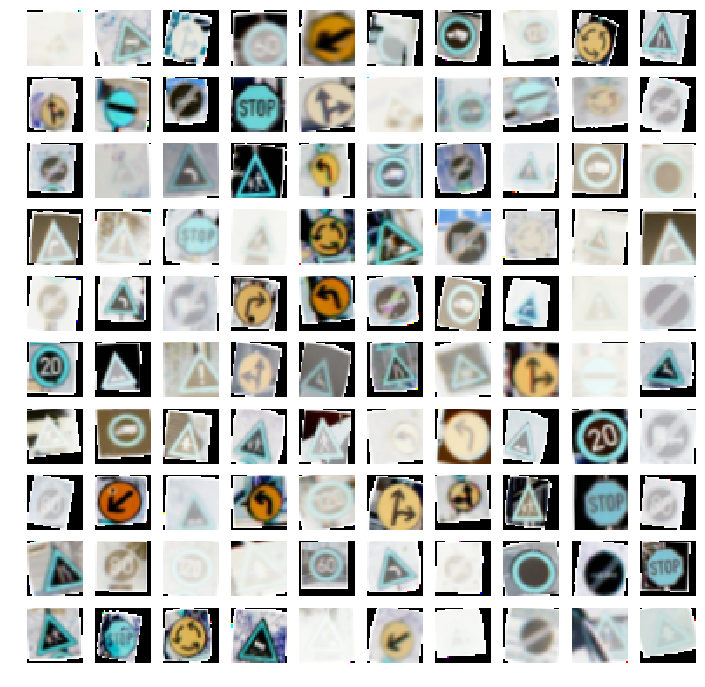

In [7]:
#Code for data augmentation

label_idx_dict = {}
label_count = []
for i in range(n_classes):
    label_count.append(0)
    label_idx_dict[i] = []
for i in range(len(y_train)):
    label_count[y_train[i]] += 1
    label_idx_list = label_idx_dict[y_train[i]]
    if not label_idx_list:
        label_idx_dict[y_train[i]] = [i]
    else:
        label_idx_list.append(i)
print('mean of label_count = %d' %np.mean(label_count))
X_aug = []
y_aug = []
top_label_count = max(label_count)
print('top_label_count is %d.' % top_label_count)
#a = np.random.randint(0, len(label_idx_dict[0]), size = 300)
#print(a)
for i in range(len(label_count)):
    this_img_count = label_count[i]
    #print('image count for label %d is %d.' % (i, this_img_count))
    num_img_to_build = top_label_count - this_img_count
    #print('Number of image to build for label %d is %d.' % (i, num_img_to_build))
    img_idx_list = label_idx_dict[i]
    for j in (np.random.randint(0, len(img_idx_list), size = num_img_to_build)):
        img_aug = transform_image(X_train[img_idx_list[j]],30,5,5)
        X_aug.append(img_aug)
        y_aug.append(i)#label for this augmented image
        
X_aug = np.array(X_aug,dtype = np.float32())
y_aug = np.array(y_aug,dtype = np.float32())
print("Number of Augmented training examples =", X_aug.shape)
print("Number of Augmented training example labels =", y_aug.shape)
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
plt.figure(figsize=(12,12))
random_image_idx = random.sample(range(0, X_aug.shape[0]), 100)
for i in range(100):   #plot some random images from training set
    plt.subplot(10,10,i+1)
    plt.imshow(X_aug[random_image_idx[i]])
    plt.axis('off')
plt.show()

 X_train.shape= (39209, 32, 32, 3)
 X_aug.shape= (57541, 32, 32, 3)
 y_train.shape= (39209,)
 y_aug.shape= (57541,)
Total Train image shape =  (96750, 32, 32, 3)
Total Train label shape =  (96750,)


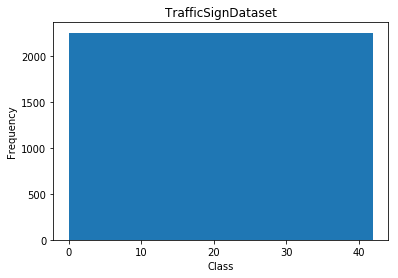

Training data set distribution before data augmentation


In [8]:
#append augmented data to actual training data

print(" X_train.shape=", X_train.shape)
print(" X_aug.shape=", X_aug.shape)
print(" y_train.shape=", y_train.shape)
print(" y_aug.shape=", y_aug.shape)
X_train_tmp = np.concatenate((X_train, X_aug), axis = 0)
y_train_tmp = np.concatenate((y_train, y_aug), axis = 0)              

print("Total Train image shape = ", X_train_tmp.shape)
print("Total Train label shape = ", y_train_tmp.shape)
plt.hist(y_train_tmp, n_classes)
plt.title("TrafficSignDataset")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
print("Training data set distribution before data augmentation")


In [9]:
#Shuffle the agmented data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train_tmp, y_train_tmp)
#X_train, y_train = shuffle(X_train, y_train)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [10]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.
X_train_tmp = np.zeros((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
for i in range(X_train.shape[0]):
    img = preprocess_img(X_train[i]) 
    X_train_tmp[i] = img[:, :, np.newaxis] #expanding dimenstion 32X32 ---> 32X32X1
X_train = X_train_tmp

X_test_tmp = np.zeros((X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
for i in range(X_test.shape[0]):
    img = preprocess_img(X_test[i])
    X_test_tmp[i] = img[:, :, np.newaxis] #expanding dimenstion 32X32 ---> 32X32X1
X_test = X_test_tmp
print("X_train.shape = ",X_train.shape)
print("X_test.shape = ",X_test.shape)

X_train.shape =  (96750, 32, 32, 1)
X_test.shape =  (12630, 32, 32, 1)


### Split Data into Training, Validation and Testing Sets

In [11]:
### Split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.1, random_state = 0)
print("Number of final training examples =", X_train.shape[0])
print("Number of validation examples =", X_validation.shape[0])

Number of final training examples = 87075
Number of validation examples = 9675


In [12]:
import tensorflow as tf

EPOCHS = 45
BATCH_SIZE = 256

### Model Architecture

In [13]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1
w1 = tf.Variable(tf.truncated_normal([5, 5, 1, 6], mu, sigma))
w1_conv1 = tf.Variable(tf.truncated_normal([5, 5, 6, 6], mu, sigma))

w2 = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mu, sigma))
w2_conv1 = tf.Variable(tf.truncated_normal([5, 5, 16, 16], mu, sigma))


w4 = tf.Variable(tf.truncated_normal([400, 120], mu, sigma))
w5 = tf.Variable(tf.truncated_normal([120, 84], mu, sigma))
w6 = tf.Variable(tf.truncated_normal([84, 43], mu, sigma))

keep_prob = tf.placeholder(tf.float32)

def LeNet(x):    
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    c1 = tf.nn.conv2d(x, w1, [1, 1, 1, 1], 'VALID')
    b1 = tf.nn.bias_add(c1, tf.Variable(tf.truncated_normal([6])))
    
    # Activation.
    a1 = tf.nn.relu(b1)
    
    c1_conv1 = tf.nn.conv2d(a1, w1_conv1, [1, 1, 1, 1], 'SAME')
    b1_conv1 = tf.nn.bias_add(c1_conv1, tf.Variable(tf.truncated_normal([6])))
    
    #Activation.
    a1_conv1 = tf.nn.relu(b1_conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    p1 = tf.nn.max_pool(a1_conv1, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    
    #dropout
    d1 = tf.nn.dropout(p1, keep_prob = keep_prob)
    #print(d1)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    c2 = tf.nn.conv2d(d1, w2, [1, 1, 1, 1], 'VALID')
    b2 = tf.nn.bias_add(c2, tf.Variable(tf.truncated_normal([16])))
    
    #Activation
    a2 = tf.nn.relu(b2)
    
    c2_conv1 = tf.nn.conv2d(a2, w2_conv1, [1, 1, 1, 1], 'SAME')
    b2_conv1 = tf.nn.bias_add(c2_conv1, tf.Variable(tf.truncated_normal([16])))
    
    # Activation.
    a2_conv1 = tf.nn.relu(b2_conv1)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    p2 = tf.nn.max_pool(a2_conv1, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    
    #dropout
    d2 = tf.nn.dropout(p2, keep_prob = keep_prob)
    #print(d2)

    # Flatten. Input = 5x5x16. Output = 400.
    flatten = tf.contrib.layers.flatten(d2)
    #print(flatten)
    
    # Layer 4: Fully Connected. Input = 400. Output = 120.
    fcl4 = tf.add(tf.matmul(flatten, w4), tf.Variable(tf.truncated_normal([120], mu, sigma)))
    
    # Activation.
    a4 = tf.nn.relu(fcl4)
    
    #dropout
    d4 = tf.nn.dropout(a4, keep_prob = keep_prob)

    # Layer 5: Fully Connected. Input = 120. Output = 84.
    fcl5 = tf.add(tf.matmul(d4, w5), tf.Variable(tf.truncated_normal([84], mu, sigma)))
    
    # Activation.
    #a4 = tf.nn.relu(fcl4)

    # Layer 6: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(fcl5, w6), tf.Variable(tf.truncated_normal([43], mu, sigma)))
    
    return logits

In [14]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [15]:
rate = 0.001

logits = LeNet(x)
regularizers = (tf.nn.l2_loss(w1)
                + tf.nn.l2_loss(w1_conv1) + tf.nn.l2_loss(w2)
                + tf.nn.l2_loss(w2_conv1) + tf.nn.l2_loss(w4)
                + tf.nn.l2_loss(w5) + tf.nn.l2_loss(w6))
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)+1e-5*regularizers
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [16]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0;
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, loss = sess.run([accuracy_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return (total_accuracy / num_examples, total_loss/num_examples)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [17]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
import time as time

batch_acc_list = []
batch_loss_list = []

valid_acc_list = []
valid_loss_list = []

train_acc_list = []
train_loss_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    start_time = time.time()
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        batch_x = []
        batch_y = []
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            batch_accuracy, batch_loss = evaluate(batch_x, batch_y)
            batch_acc_list.append(batch_accuracy)
            batch_loss_list.append(batch_loss)
        
        train_accuracy, train_loss = evaluate(X_train, y_train)
        train_acc_list.append(train_accuracy)
        train_loss_list.append(train_loss)
        
        validation_accuracy, validation_loss = evaluate(X_validation, y_validation)
        valid_acc_list.append(validation_accuracy)
        valid_loss_list.append(validation_loss)
        
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    saver.save(sess, './TrafficSignClassifier_with_augmentation')
    print("Model saved")
    end_time = time.time()
    print("time taken to complete traing = ",(end_time-start_time))

Training...

EPOCH 1 ...
Train Accuracy = 0.025
Validation Accuracy = 0.024

EPOCH 2 ...
Train Accuracy = 0.027
Validation Accuracy = 0.025

EPOCH 3 ...
Train Accuracy = 0.037
Validation Accuracy = 0.035



KeyboardInterrupt: 

In [ ]:
plt.plot(train_acc_list, color = "red", label='train_acc')
plt.plot(valid_acc_list, color = "green", label='valid_acc')
plt.legend(loc='best')
#plt.xlim(.25,1.1)
#plt.ylim(0,800)

In [ ]:
#print(valid_loss_list)
plt.plot(train_loss_list, color = "red", label="train_loss")
plt.plot(valid_loss_list, color = "green", label="valid_loss")
plt.legend(loc='best')

In [ ]:
plt.plot(batch_loss_list, color = "red", label="batch_loss")
plt.plot(batch_acc_list, color = "green", label="batch_acc")
plt.legend(loc='best')

# Evaluate the model on test data

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy, test_loss = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    #print("Test loss = {:.3f}".format(test_loss))

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
test_imag_list = os.listdir('test-from-web/')
print(test_imag_list)
X_web_test = np.zeros((len(test_imag_list), 32, 32, 1))
#y_web_test = np.array([40,33,27,3,24])#class labels
img_to_label = {'1.jpg':40, '2.jpg':33, '3.jpg':27, '4.jpg':3, '5.jpg':24}
y_web_test = np.array([0,0,0,0,0])#class labels
test_image_num = 0
for i in range(len(test_imag_list)):
    img = test_imag_list[i]
    y_web_test[i] = img_to_label[img]
    read_img = cv2.imread('test-from-web/'+img, cv2.IMREAD_GRAYSCALE)
    resized_image = cv2.resize(read_img, (32, 32)) #resize the image to 32X32X1
    cv2.imwrite('preprocessed/'+img[0:-4]+'resized.jpg', resized_image)
    img_normalized = ((resized_image - np.min(resized_image)) * 255.) / ( np.max(resized_image) -  np.min(resized_image)) #normalize
    re_dim_image = resized_image[:, :, np.newaxis]
    X_web_test[test_image_num] = re_dim_image
    test_image_num += 1
gs1 = gridspec.GridSpec(2, 4)
#gs1.update(wspace=0.01, hspace=0.01) # set the spacing between axes.
plt.figure(figsize=(20,20))
for i in range(len(test_imag_list)): #plot images downloaded from web
    plt.subplot(2,4,i+1)
    plt.imshow(cv2.imread('test-from-web/'+test_imag_list[i]))
    plt.text(4,8,str(y_web_test[i]),color='k',backgroundcolor='c')
    plt.axis('off')
plt.show()

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
predictions = [] 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(tf.nn.softmax(logits), feed_dict={x: X_web_test, keep_prob:1.0})
    print(predictions)

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy, test_loss = evaluate(X_web_test, y_web_test)
    print("Test Accuracy on new data= {:.3f}".format(test_accuracy))
    #print("Test Loss on new data= {:.3f}".format(test_loss))

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    print(sess.run(tf.nn.top_k(predictions, k=5,  sorted=True)))

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 